# **Importing Libraries**

In [628]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# **Importing Dataset**

In [629]:
def import_dataset(path: str ,nrows: int | None = None) -> pd.DataFrame:
    train_df = pd.read_csv(path, nrows=nrows)

    machine_area_df = pd.read_csv("dataset/Machine-Area.csv")
    machine_list_df = pd.read_csv("dataset/Machine-List.csv")
    area_list_df = pd.read_csv("dataset/Area-List.csv")

    machine_area_df['Last Maintenance'] = pd.to_datetime(machine_area_df['Last Maintenance'])
    machine_area_filtered_df = machine_area_df.sort_values(by=['ID_Area', 'ID_Mesin', 'Last Maintenance'], ascending=[True, True, False])
    machine_area_filtered_df = machine_area_filtered_df.drop_duplicates(subset=['ID_Area', 'ID_Mesin'], keep='first')

    combined_df = pd.merge(train_df, area_list_df, on='ID_Area', how='left')
    combined_df = pd.merge(combined_df, machine_list_df, left_on='Machine', right_on='ID_Mesin', how='left')
    combined_df = pd.merge(combined_df, machine_area_filtered_df, left_on=['Machine', 'ID_Area'], right_on=['ID_Mesin', 'ID_Area'], how='left')

    return combined_df
    

In [630]:
train_df = import_dataset(
    path="dataset/train.csv", 
    nrows=1_000_000)

In [631]:
test_df = import_dataset(
    path="dataset/test.csv", 
    nrows=200_000)

In [632]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, test_index in strat_split.split(train_df, train_df['Status']):
    train_df = train_df.iloc[test_index]

In [633]:
train_df = train_df.drop(columns=['ID_Transaction'])

In [634]:
train_df.columns

Index(['temperature_10H_max (°C)', 'temperature_10H_min (°C)', 'temperature-1',
       'temperature-2', 'temperature-3', 'apparent_temperature_max',
       'apparent_temperature_min', 'ID_Area', 'Machine', 'timestamp',
       'humidity', 'Voltage-L', 'Voltage-R', 'Voltage-M', 'Current-M',
       'Current-R', 'Current-T', 'RPM', 'RPM-1', 'RPM-2', 'RPM-3',
       'Vibration-1', 'Vibration-2', 'Power', 'Power_Backup', 'Status',
       'Breakdown Category', 'Area', 'Priority', 'ID_Mesin_x', 'Mesin_x',
       'Country Machine_x', 'ID_Mesin_y', 'Mesin_y', 'Country Machine_y',
       'Last Maintenance', 'Status Sparepart', 'Age'],
      dtype='object')

# **Data Cleaning**

## Identify Missing Data

In [635]:
missing = train_df.isnull().sum()
missing_percentage = missing / len(train_df) * 100
print(missing_percentage)

temperature_10H_max (°C)     2.8772
temperature_10H_min (°C)    19.1994
temperature-1                2.8984
temperature-2               11.6128
temperature-3                3.5674
apparent_temperature_max    21.2328
apparent_temperature_min    20.1262
ID_Area                     17.2844
Machine                     16.9086
timestamp                    0.0000
humidity                    19.4758
Voltage-L                    9.6194
Voltage-R                    6.8952
Voltage-M                    3.4110
Current-M                    1.1008
Current-R                    1.3642
Current-T                   22.6958
RPM                         11.0316
RPM-1                       13.4344
RPM-2                       18.7208
RPM-3                       18.1432
Vibration-1                  5.3650
Vibration-2                 15.1628
Power                       13.0896
Power_Backup                 3.3980
Status                       0.0000
Breakdown Category          73.7994
Area                        

## Handling Missing Data

In [636]:
columns_to_impute = missing_percentage[missing_percentage < 5].index
for col in columns_to_impute:
    if train_df[col].dtype in ['float64', 'int64']:
        train_df[col] = train_df[col].fillna(train_df[col].median())

In [637]:
def random_sample_impute(series):
    non_missing = series.dropna()
    return series.apply(lambda x: np.random.choice(non_missing) if pd.isnull(x) else x)

In [638]:
from sklearn.impute import KNNImputer
def knn_impute_single_column(series, n_neighbors=2):
    series_df = series.to_frame()
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_array = knn_imputer.fit_transform(series_df)
    return pd.Series(imputed_array.ravel(), index=series.index, name=series.name)

In [639]:
moderate_missingness_cols = missing_percentage[(missing_percentage >= 5) & (missing_percentage <= 23)].index
numerical_cols = [col for col in moderate_missingness_cols if train_df[col].dtype in ['float64', 'int64']]

for col in numerical_cols:
    train_df[col] = random_sample_impute(train_df[col])
    print(f"Imputed {col}")

Imputed temperature_10H_min (°C)
Imputed temperature-2
Imputed apparent_temperature_max
Imputed apparent_temperature_min
Imputed humidity
Imputed Voltage-L
Imputed Voltage-R
Imputed Current-T
Imputed RPM
Imputed RPM-1
Imputed RPM-2
Imputed RPM-3
Imputed Vibration-1
Imputed Vibration-2
Imputed Power


In [640]:
missing = train_df.isnull().sum()
missing_percentage = missing / len(train_df) * 100
print(missing_percentage)

temperature_10H_max (°C)     0.0000
temperature_10H_min (°C)     0.0000
temperature-1                0.0000
temperature-2                0.0000
temperature-3                0.0000
apparent_temperature_max     0.0000
apparent_temperature_min     0.0000
ID_Area                     17.2844
Machine                     16.9086
timestamp                    0.0000
humidity                     0.0000
Voltage-L                    0.0000
Voltage-R                    0.0000
Voltage-M                    0.0000
Current-M                    0.0000
Current-R                    0.0000
Current-T                    0.0000
RPM                          0.0000
RPM-1                        0.0000
RPM-2                        0.0000
RPM-3                        0.0000
Vibration-1                  0.0000
Vibration-2                  0.0000
Power                        0.0000
Power_Backup                 3.3980
Status                       0.0000
Breakdown Category          73.7994
Area                        

In [641]:
train_df['Age'] = train_df['Age'].fillna(-1)

## Dealing with Outliers

## Remove Duplicates

## Feature Engineering

# **Data Preprocessing**

## Feature Scaling

In [642]:
numerical_cols = [col for col in train_df.columns if train_df[col].dtype in ['float64', 'int64']]
scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])


## Feature Encoding

In [643]:
categorical_cols = [col for col in train_df.columns if col not in numerical_cols]

In [646]:
def one_hot_encode(df, cols):
    if df[col].isnull().any():
        df[col] = df[col].fillna("Missing")
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    onehot_encoded = encoder.fit_transform(df[[cols]])
    encoded_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out([cols]), index = df.index)
    df_encoded = pd.concat([df.drop(columns=cols), encoded_df], axis=1)
    return df_encoded

In [647]:
train_df = one_hot_encode(train_df, 'Priority')

In [649]:
train_df = one_hot_encode(train_df, 'Status Sparepart') 

In [679]:
train_df = one_hot_encode(train_df, 'Power_Backup')

In [650]:
train_df.isnull().sum()

temperature_10H_max (°C)          0
temperature_10H_min (°C)          0
temperature-1                     0
temperature-2                     0
temperature-3                     0
apparent_temperature_max          0
apparent_temperature_min          0
ID_Area                       86422
Machine                       84543
timestamp                         0
humidity                          0
Voltage-L                         0
Voltage-R                         0
Voltage-M                         0
Current-M                         0
Current-R                         0
Current-T                         0
RPM                               0
RPM-1                             0
RPM-2                             0
RPM-3                             0
Vibration-1                       0
Vibration-2                       0
Power                             0
Power_Backup                  16990
Status                            0
Breakdown Category           368997
Area                        

## Handling Imbalanced Dataset

## Dimensionality Reduction

### bisa pake feature hasher buat categorical

In [651]:
from tensorflow.keras.utils import to_categorical
X = train_df[numerical_cols]
y = train_df['Status'].map({'Normal': 0, 'Warning': 1, 'Breakdown': 2})

# y_one_hot = to_categorical(y, num_classes=3)


In [652]:
# from sklearn.feature_selection import SelectKBest, f_classif

# selector = SelectKBest(score_func=f_classif, k=3)
# X_reduced = selector.fit_transform(X, y)


In [653]:
# X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [654]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_dim = X.shape[1]
encoding_dim = 3

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

encoder_model = Model(inputs=input_layer, outputs=encoder)
X_reduced = encoder_model.predict(X)


Epoch 1/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 11s 823us/step - loss: 0.9802 - val_loss: 0.8981
Epoch 2/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 10s 814us/step - loss: 0.9219 - val_loss: 0.8951
Epoch 3/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 10s 762us/step - loss: 0.9143 - val_loss: 0.8932
Epoch 4/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 10s 832us/step - loss: 0.9359 - val_loss: 0.8897
Epoch 5/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 10s 783us/step - loss: 0.9149 - val_loss: 0.8879
Epoch 6/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 10s 778us/step - loss: 0.9034 - val_loss: 0.8874
Epoch 7/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 10s 786us/step - loss: 0.9076 - val_loss: 0.8871
Epoch 8/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 10s 821us/step - loss: 0.8938 - val_loss: 0.8870
Epoch 9/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 12s 986us/step - loss: 0.8977 - val_loss: 0.8868
Epoch 10/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.9198 - val_loss: 0.8865
Epoch 11/50
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.912

In [655]:
X_reduced = pd.DataFrame(X_reduced, columns=[f'component_{i}' for i in range(encoding_dim)])

In [680]:
train_df = train_df.reset_index(drop=True)
X_reduced = X_reduced.reset_index(drop=True)
reduced_df = pd.concat([train_df.drop(columns=numerical_cols), X_reduced], axis=1)


In [682]:
reduced_df.drop(columns=['ID_Area', 'ID_Mesin_x', 'Machine', 'timestamp', 'Status',
       'Breakdown Category', 'Area', 'ID_Mesin_x', 'Mesin_x',
       'Country Machine_x', 'ID_Mesin_y', 'Mesin_y', 'Country Machine_y',
       'Last Maintenance'], inplace=True)

In [689]:
train_df['Area'].value_counts()

Area
JGJ     23880
BNTN    22876
BGR     20909
BPN     20768
TGR     20549
SKBM    20481
BKS     20394
PLKG    19879
SRBY    19856
BDG     19670
MKS     19614
MLG     19586
BFMG    19212
KRWG    19198
KLT     19035
SMGS    18821
KDR     18691
LMPG    17983
MKSR    16900
SRG     16698
BLJA     9311
SDA      9267
Name: count, dtype: int64

In [683]:
X_train, X_test, y_train, y_test = train_test_split(reduced_df, y, test_size=0.2, random_state=42)

In [684]:
X_train.columns

Index(['Priority_High', 'Priority_Low', 'Priority_Medium', 'Priority_nan',
       'Status Sparepart_Broken', 'Status Sparepart_Empty',
       'Status Sparepart_In Use', 'Status Sparepart_On Check',
       'Status Sparepart_Ready', 'Status Sparepart_Repair',
       'Status Sparepart_nan', 'Power_Backup_No', 'Power_Backup_Yes',
       'Power_Backup_nan', 'component_0', 'component_1', 'component_2'],
      dtype='object')

# **Modelling & Validation**

In [685]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
def precision_recall_f1(tp, fp, fn):
    # Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F1 Score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    return precision, recall, f1

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [686]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76     61285
           1       0.27      0.00      0.00     19610
           2       0.32      0.00      0.00     19105

    accuracy                           0.61    100000
   macro avg       0.40      0.33      0.25    100000
weighted avg       0.49      0.61      0.47    100000



In [687]:
report = classification_report(y_test, y_pred, output_dict=True)
macro_f1 = report['macro avg']['f1-score']
print(f"Macro F1-Score: {macro_f1}")

Macro F1-Score: 0.25380115555892097


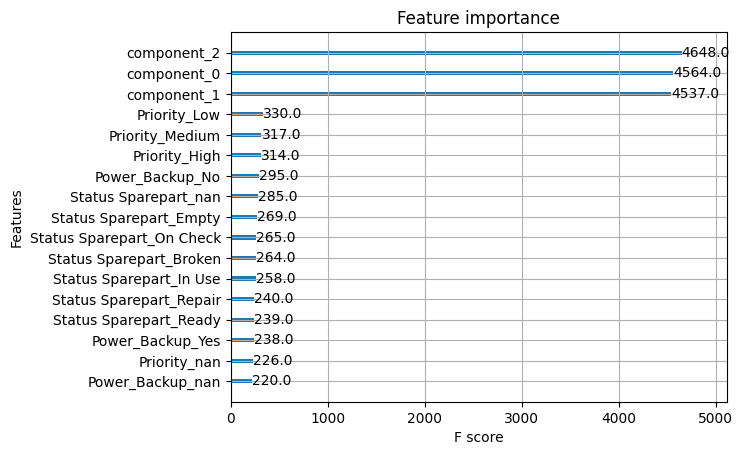

In [688]:
#feature importance
xgb.plot_importance(xgb_model)
plt.show()

# **Result & Analysis**